## Imports

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
import keras.utils as np_utils
import tensorflow as tf

from manifold_angles import ManifoldAngles

In [2]:
with open('./cached/mnist_input_curv', 'rb') as file:
  input_class_curvatures = pickle.load(file)
with open('./cached/mnist_output_curv', 'rb') as file:
  output_class_curvatures = pickle.load(file)
  
datasizes = np.logspace(3.699, 2.599, 20).astype('int')

In [3]:
(X_train, train_y), (X_test, test_y) = mnist.load_data()

X_train = X_train / 255
X_test = X_test/ 255

Y_train = np_utils.to_categorical(train_y, 10)
Y_test = np_utils.to_categorical(test_y, 10)

In [4]:
def create_model():
  model = Sequential()
  model.add(Conv2D(50, kernel_size=(28,28), input_shape=(28,28,1), activation='PReLU',use_bias=False, kernel_initializer='random_uniform', padding='valid'))
  model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
  model.add(Dense(10, activation='softmax', kernel_initializer= 'random_uniform'))

  return model

## Define classes and functions

In [5]:
def shuffle_data(X: np.ndarray, Y: np.ndarray, seed: int):
  np.random.seed(seed)
  np.random.shuffle(X)
  np.random.seed(seed)
  np.random.shuffle(Y)

In [6]:
def get_reduced_datasets(data_size: int, X: np.ndarray, Y: np.ndarray, order_method: str, curvature_set='input'):

  _input_curvatures = input_class_curvatures
  _output_curvatures = output_class_curvatures
  _train_y = train_y

  _curvature_set = _input_curvatures if curvature_set == 'input' else _output_curvatures

  for y_class in range(10):
    class_indices = _train_y == y_class
    keep_indices = None
    if order_method == 'random':
      keep_indices = np.random.choice(X[class_indices].shape[0], data_size)
    elif order_method == 'low_to_high':
      keep_indices = np.argsort(_curvature_set[y_class][:, 0])[:data_size]
    elif order_method == 'high_to_low':
      keep_indices = np.argsort(_curvature_set[y_class][:, 0])[-data_size:]
    elif order_method == 'extremes':
      return get_reduced_datasets_extremes(data_size, X, Y, curvature_set)
    elif order_method == 'mid':
      num_low_curv = data_size // 2
      num_high_curv = data_size - num_low_curv

      curv_midpoint = _curvature_set[y_class][:, 0].shape[0] // 2

      keep_indices = np.argsort(_curvature_set[y_class][:, 0])[curv_midpoint - num_low_curv : curv_midpoint + num_high_curv]
    elif order_method == 'ratio_low_to_high':
      ratios = _output_curvatures[y_class][:, 0] / _input_curvatures[y_class][:, 0]
      keep_indices = np.argsort(ratios)[:data_size]
    elif order_method == 'ratio_high_to_low':
      ratios = _output_curvatures[y_class][:, 0] / _input_curvatures[y_class][:, 0]
      keep_indices = np.argsort(ratios)[-data_size:]
    else:
      raise ValueError(f"order method not implemented: {order_method}")

    new_x_row = X[class_indices][keep_indices]
    new_y_row = Y[class_indices][keep_indices]

    Reduced_X = np.vstack([Reduced_X, new_x_row]) if y_class > 0 else new_x_row
    Reduced_Y = np.vstack([Reduced_Y, new_y_row]) if y_class > 0 else new_y_row

  return Reduced_X, Reduced_Y

def get_reduced_datasets_extremes(data_size: int, X: np.ndarray, Y: np.ndarray, curvature_set='input'):
  _curvature_set = input_class_curvatures if curvature_set == 'input' else output_class_curvatures
  num_low_curv = data_size // 2
  num_high_curv = data_size - num_low_curv
  for y_class in range(10):
    class_indices = train_y == y_class
    argsorted_curvatures = np.argsort(_curvature_set[y_class][:, 0])
    low_curv_indices = argsorted_curvatures[:num_low_curv]
    high_curv_indices = argsorted_curvatures[-num_high_curv:]

    new_x_rows = np.vstack([X[class_indices][low_curv_indices], X[class_indices][high_curv_indices]])
    new_y_rows = np.vstack([Y[class_indices][low_curv_indices], Y[class_indices][high_curv_indices]])

    Reduced_X = np.vstack([Reduced_X, new_x_rows]) if y_class > 0 else new_x_rows
    Reduced_Y = np.vstack([Reduced_Y, new_y_rows]) if y_class > 0 else new_y_rows

  return Reduced_X, Reduced_Y

In [7]:
def get_accuracies(X_train, Y_train, X_test, Y_test, order_method='low_to_high', curvature_set='input', num_models=5, shuffle_seed=None):
  valacclist = []
  acclist = []
  for data_size in datasizes:
    Reduced_X_train, Reduced_Y_train = get_reduced_datasets(data_size, X_train, Y_train, order_method, curvature_set)
    print(f'ReducedX.shape: {Reduced_X_train.shape}')

    if shuffle_seed is not None:
      shuffle_data(Reduced_X_train, Reduced_Y_train, shuffle_seed)

    valacclist.append([])
    acclist.append([])
    for _ in range(num_models):
      nt = create_model()
      nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
      history = nt.fit(Reduced_X_train, Reduced_Y_train, epochs=20, validation_data=(X_test, Y_test), verbose=0, batch_size = 128)
      del nt
      print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
      valacclist[-1].append(history.history['val_categorical_accuracy'][-1])
      acclist[-1].append(history.history['categorical_accuracy'][-1])
      del history

  return valacclist, acclist

In [8]:
def plot_accuracies(accuracies, names=None):
  plt.figure(figsize=(14, 10))
  for acclist in accuracies:
    plt.plot(datasizes, np.mean(acclist, axis=1))

  if names is not None:
    plt.legend(names, fontsize=11)

  plt.xscale('log')
  plt.gca().invert_xaxis()
  plt.grid()
  plt.show()

## Mnist

In [9]:
@tf.function
def get_hessian2(model,input,target, lossfunc = tf.keras.losses.CategoricalCrossentropy()):
	with tf.GradientTape() as t2:
		t2.watch(input)
		with tf.GradientTape() as t1:
			t1.watch(input)
			loss = lossfunc(model(input),target)
		g=t1.gradient(loss,input)
	return t2.jacobian(g,input)

In [10]:
def jacobian(model, input, target, lossfunc=tf.keras.losses.CategoricalCrossentropy()):
	_input, _target = tf.convert_to_tensor(input), tf.convert_to_tensor(target)
	with tf.GradientTape() as tape:
		tape.watch(_input)
		out = model(_input)
		loss = lossfunc(out, _target)
		return np.array(tape.jacobian(loss, _input))

In [11]:
nt = create_model()
#CustomOpt = tf.keras.optimizers.Adam(    learning_rate= 10e-3 )
nt.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
history  = nt.fit(X_train, Y_train, epochs=150, validation_data=(X_test, Y_test), verbose=1, batch_size=128) #, callbacks=[callback]
print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")

Epoch 1/150
469/469 [==============================] - 2s 2ms/step - loss: 0.5576 - categorical_accuracy: 0.8657 - val_loss: 0.2765 - val_categorical_accuracy: 0.9192
Epoch 2/150
469/469 [==============================] - 1s 2ms/step - loss: 0.2492 - categorical_accuracy: 0.9290 - val_loss: 0.2066 - val_categorical_accuracy: 0.9406
Epoch 3/150
469/469 [==============================] - 1s 2ms/step - loss: 0.1854 - categorical_accuracy: 0.9466 - val_loss: 0.1619 - val_categorical_accuracy: 0.9535
Epoch 4/150
469/469 [==============================] - 1s 2ms/step - loss: 0.1477 - categorical_accuracy: 0.9578 - val_loss: 0.1385 - val_categorical_accuracy: 0.9586
Epoch 5/150
469/469 [==============================] - 1s 2ms/step - loss: 0.1243 - categorical_accuracy: 0.9637 - val_loss: 0.1239 - val_categorical_accuracy: 0.9630
Epoch 6/150
469/469 [==============================] - 1s 2ms/step - loss: 0.1070 - categorical_accuracy: 0.9689 - val_loss: 0.1136 - val_categorical_accuracy: 0.964

In [12]:
output_curvatures = []
for y_class in range(10):
	print(f'     Generating curvature for class {y_class}...')
	class_inputs = X_train[train_y == y_class]
	class_predictions = nt(class_inputs)
	# try inputs here
	_, manifold_neighbour_angle_sum = ManifoldAngles([class_predictions], classsize=1, neighboursize1=10, dim_reduc_size=5) # check if the reduction quality is low, if so raise numneighbors/reduction size
	output_curvatures.append(np.array(manifold_neighbour_angle_sum))
	del _, manifold_neighbour_angle_sum

     Generating curvature for class 0...
start: 
--layer time:  19.1835880279541
--angle time:  137.4935519695282
Average reduction quality:  0.998673916
endtime:  156.70774412155151
     Generating curvature for class 1...
start: 
--layer time:  20.167627096176147
--angle time:  173.28203797340393
Average reduction quality:  0.998275161
endtime:  193.46303296089172
     Generating curvature for class 2...
start: 
--layer time:  23.065077066421509
--angle time:  164.44864916801453
Average reduction quality:  0.998747
endtime:  187.526349067688
     Generating curvature for class 3...
start: 
--layer time:  23.595909833908081
--angle time:  170.21976399421692
Average reduction quality:  0.998991132
endtime:  193.83165407180786
     Generating curvature for class 4...
start: 
--layer time:  22.539190053939819
--angle time:  157.91140198707581
Average reduction quality:  0.998332322
endtime:  180.46243977546692
     Generating curvature for class 5...
start: 
--layer time:  17.87979698181

In [13]:
with open('./cached/mnist_output_curv', 'wb') as file:
  pickle.dump(output_curvatures, file)

In [14]:
# test mnist hessian reduction vs. approximation (output curvature based) vs concatenated approximation
# this code is also somewhere in bahadir's files he sent over, so try and find if necessary

lowersize = 20
s,u,v = tf.linalg.svd(X_train.reshape((X_train.shape[0], 28*28)))
layerdata = (u[:,:lowersize] * s[:lowersize]).numpy()
tf.print('layer quality: ', tf.norm(s[:lowersize]) / tf.norm(s))

# layerdata = batch size x 20 dimensional
reduced_input  = layerdata @ v[:lowersize,:]# or layerdata * v[:lowersize,:]
del s,u,v

predictions = nt(X_train)

layerfeatlist = [layerdata , predictions.numpy()]
print(layerdata.shape)
print(predictions.shape)
layerfeatlist = np.hstack(layerfeatlist)
print(layerfeatlist.shape)

concat_curvatures = []
for y_class in range(10):
	print(f'     Generating curvature for class {y_class}...')
	class_concats = layerfeatlist[train_y == y_class]
	# try inputs here
	_, manifold_neighbour_angle_sum = ManifoldAngles([class_concats], classsize=1, neighboursize1=10, dim_reduc_size=5) # check if the reduction quality is low, if so raise numneighbors/reduction size
	concat_curvatures.append(np.array(manifold_neighbour_angle_sum))
	del _, manifold_neighbour_angle_sum

# send layer feat list to curvature calculation
# do this one, and also test MNIST with hessian reduction + approximation reduction

layer quality:  0.88644200066907741
(60000, 20)
(60000, 10)
(60000, 30)
     Generating curvature for class 0...
start: 
--layer time:  20.804638147354126
--angle time:  146.81068801879883
Average reduction quality:  0.74138504005753247
endtime:  167.62785291671753
     Generating curvature for class 1...
start: 
--layer time:  24.551753044128418
--angle time:  173.56265091896057
Average reduction quality:  0.77235518753488774
endtime:  198.1277859210968
     Generating curvature for class 2...
start: 
--layer time:  21.493159055709839
--angle time:  156.34206390380859
Average reduction quality:  0.73169522156725808
endtime:  177.85019683837891
     Generating curvature for class 3...
start: 
--layer time:  22.132967233657837
--angle time:  154.00619912147522
Average reduction quality:  0.72117977033724012
endtime:  176.15195202827454
     Generating curvature for class 4...
start: 
--layer time:  21.034852981567383
--angle time:  151.87766885757446
Average reduction quality:  0.734901

In [15]:
with open('./cached/mnist_concat_curv', 'wb') as file:
  pickle.dump(concat_curvatures, file)

In [16]:
jacobians = jacobian(nt, X_train, Y_train)
jacobian_norms = tf.norm(jacobians, axis=(1, 2))

In [17]:
Heslist = []
lossfunc = tf.keras.losses.CategoricalCrossentropy()
for i in range(X_train.shape[0]):
	print(f'{i}/{X_train.shape[0]+1}')
	Heslist.append(np.linalg.norm(get_hessian2(nt,X_train[i:i+1],Y_train[i:i+1],lossfunc=lossfunc)[0]))

Heslist = np.array(Heslist)


0/60001
1/60001
2/60001
3/60001
4/60001
5/60001
6/60001
7/60001
8/60001
9/60001
10/60001
11/60001
12/60001
13/60001
14/60001
15/60001
16/60001
17/60001
18/60001
19/60001
20/60001
21/60001
22/60001
23/60001
24/60001
25/60001
26/60001
27/60001
28/60001
29/60001
30/60001
31/60001
32/60001
33/60001
34/60001
35/60001
36/60001
37/60001
38/60001
39/60001
40/60001
41/60001
42/60001
43/60001
44/60001
45/60001
46/60001
47/60001
48/60001
49/60001
50/60001
51/60001
52/60001
53/60001
54/60001
55/60001
56/60001
57/60001
58/60001
59/60001
60/60001
61/60001
62/60001
63/60001
64/60001
65/60001
66/60001
67/60001
68/60001
69/60001
70/60001
71/60001
72/60001
73/60001
74/60001
75/60001
76/60001
77/60001
78/60001
79/60001
80/60001
81/60001
82/60001
83/60001
84/60001
85/60001
86/60001
87/60001
88/60001
89/60001
90/60001
91/60001
92/60001
93/60001
94/60001
95/60001
96/60001
97/60001
98/60001
99/60001
100/60001
101/60001
102/60001
103/60001
104/60001
105/60001
106/60001
107/60001
108/60001
109/60001
110/60001


In [18]:
# output curvature based hessian norm approximation 
out_approx_valacclist = []
out_approx_acclist = []
for data_size in datasizes:
	approximations = output_curvatures[y_class] * jacobian_norms
	keep_indices = np.argsort(output_curvatures[y_class][:, 0])[-data_size:]
	Reduced_X_train, Reduced_Y_train = X_train[keep_indices], Y_train[keep_indices]
	print(f'ReducedX.shape: {Reduced_X_train.shape}')

	out_approx_valacclist.append([])
	out_approx_acclist.append([])
	for _ in range(5):
		_nt = create_model()
		_nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
		history = _nt.fit(Reduced_X_train, Reduced_Y_train, epochs=20, validation_data=(X_test, Y_test), verbose=0, batch_size = 128)
		del _nt
		print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
		out_approx_valacclist[-1].append(history.history['val_categorical_accuracy'][-1])
		out_approx_acclist[-1].append(history.history['categorical_accuracy'][-1])
		del history

ReducedX.shape: (5000, 28, 28)
  train acc = 0.9628000259399414 val acc = 0.9193999767303467
  train acc = 0.9575999975204468 val acc = 0.9180999994277954
  train acc = 0.9589999914169312 val acc = 0.9193000197410583
  train acc = 0.9585999846458435 val acc = 0.9172000288963318
  train acc = 0.9588000178337097 val acc = 0.9194999933242798
ReducedX.shape: (4376, 28, 28)
  train acc = 0.9552102088928223 val acc = 0.9114000201225281
  train acc = 0.9606946706771851 val acc = 0.9132999777793884
  train acc = 0.9602376818656921 val acc = 0.916100025177002
  train acc = 0.9577239751815796 val acc = 0.9121999740600586
  train acc = 0.9597806334495544 val acc = 0.9157999753952026
ReducedX.shape: (3830, 28, 28)
  train acc = 0.9610965847969055 val acc = 0.9114999771118164
  train acc = 0.9600521922111511 val acc = 0.9110000133514404
  train acc = 0.9610965847969055 val acc = 0.909600019454956
  train acc = 0.9634464979171753 val acc = 0.9093000292778015
  train acc = 0.9561357498168945 val acc 

In [19]:
# concatenated curvature based hessian norm approximation 
concat_approx_valacclist = []
concat_approx_acclist = []
for data_size in datasizes:
	approximations = concat_curvatures[y_class] * jacobian_norms
	keep_indices = np.argsort(output_curvatures[y_class][:, 0])[-data_size:]
	Reduced_X_train, Reduced_Y_train = X_train[keep_indices], Y_train[keep_indices]
	print(f'ReducedX.shape: {Reduced_X_train.shape}')

	concat_approx_valacclist.append([])
	concat_approx_acclist.append([])
	for _ in range(5):
		_nt = create_model()
		_nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
		history = _nt.fit(Reduced_X_train, Reduced_Y_train, epochs=20, validation_data=(X_test, Y_test), verbose=0, batch_size = 128)
		del _nt
		print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
		concat_approx_valacclist[-1].append(history.history['val_categorical_accuracy'][-1])
		concat_approx_acclist[-1].append(history.history['categorical_accuracy'][-1])
		del history

ReducedX.shape: (5000, 28, 28)
  train acc = 0.9635999798774719 val acc = 0.9190000295639038
  train acc = 0.9603999853134155 val acc = 0.9186000227928162
  train acc = 0.9584000110626221 val acc = 0.9208999872207642
  train acc = 0.9599999785423279 val acc = 0.9204999804496765
  train acc = 0.9620000123977661 val acc = 0.9193999767303467
ReducedX.shape: (4376, 28, 28)
  train acc = 0.9620658159255981 val acc = 0.9178000092506409
  train acc = 0.9689213633537292 val acc = 0.9160000085830688
  train acc = 0.9590950608253479 val acc = 0.9147999882698059
  train acc = 0.9602376818656921 val acc = 0.9090999960899353
  train acc = 0.9632084369659424 val acc = 0.9164999723434448
ReducedX.shape: (3830, 28, 28)
  train acc = 0.9634464979171753 val acc = 0.9120000004768372
  train acc = 0.9644908905029297 val acc = 0.9154000282287598
  train acc = 0.9600521922111511 val acc = 0.9114999771118164
  train acc = 0.9608355164527893 val acc = 0.9107999801635742
  train acc = 0.9650130271911621 val ac

(50000, 28, 28)
  train acc = 0.9907799959182739 val acc = 0.9704999923706055
  train acc = 0.9886999726295471 val acc = 0.9729999899864197
  train acc = 0.9903799891471863 val acc = 0.9739999771118164
  train acc = 0.991159975528717 val acc = 0.975600004196167
  train acc = 0.9905800223350525 val acc = 0.9750999808311462
(43760, 28, 28)
  train acc = 0.9845292568206787 val acc = 0.9714000225067139
  train acc = 0.9858546853065491 val acc = 0.9739000201225281
  train acc = 0.9845978021621704 val acc = 0.9718999862670898
  train acc = 0.9874771237373352 val acc = 0.973800003528595
  train acc = 0.9860146045684814 val acc = 0.9718999862670898
(38300, 28, 28)
  train acc = 0.9834203720092773 val acc = 0.972000002861023
  train acc = 0.9849869608879089 val acc = 0.9743000268936157
  train acc = 0.9844647645950317 val acc = 0.9731000065803528
  train acc = 0.9814621210098267 val acc = 0.972599983215332
  train acc = 0.9848302602767944 val acc = 0.9739000201225281
(33520, 28, 28)
  train acc

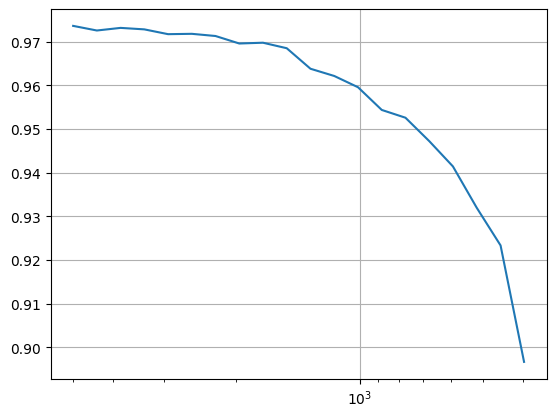

In [20]:
# normal hessian reduction
acclist = []
hess_val_acc= []
for datasize in datasizes:
  indicies = np.argsort(Heslist[train_y==0])[-datasize:]
  Reduced_X_train = X_train[train_y==0][indicies]
  Reduced_Y_train = Y_train[train_y==0][indicies]
  for c in range(1,10):
    indicies = np.argsort(Heslist[train_y==c])[-datasize:]
    Reduced_X_train = np.vstack([ Reduced_X_train, X_train[train_y==c][indicies] ])
    Reduced_Y_train = np.vstack([ Reduced_Y_train, Y_train[train_y==c][indicies] ])
  print(Reduced_X_train.shape)

  hess_val_acc.append([])
  for i in range(5):
    _nt = create_model()
    #nt.summary()
    #CustomOpt = tf.keras.optimizers.Adam(    learning_rate= 10e-3 )
    _nt.compile(loss= tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['categorical_accuracy'])
    history  = _nt.fit(Reduced_X_train, Reduced_Y_train,epochs=20,validation_data=(X_test, Y_test)  ,verbose=0, batch_size = 128  ) #, callbacks=[callback]
    print(f"  train acc = {history.history['categorical_accuracy'][-1]} val acc = {history.history['val_categorical_accuracy'][-1]}")
    #acclist.append(history.history['categorical_accuracy'][-1])
    hess_val_acc[-1].append(history.history['val_categorical_accuracy'][-1])

#plt.plot(datasizes,acclist)
plt.plot(datasizes,np.mean(hess_val_acc,axis=1))
#plt.legend(['acc ','valacc'],loc='upper right',fontsize =11)
plt.xscale('log')
plt.gca().invert_xaxis()
plt.grid()
plt.show()


In [21]:
random_val_acc, random_acc = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='random')

ReducedX.shape: (50000, 28, 28)
  train acc = 0.9957399964332581 val acc = 0.9642000198364258
  train acc = 0.9970200061798096 val acc = 0.9666000008583069
  train acc = 0.9965800046920776 val acc = 0.9684000015258789
  train acc = 0.9964600205421448 val acc = 0.9666000008583069
  train acc = 0.9964799880981445 val acc = 0.9690999984741211
ReducedX.shape: (43760, 28, 28)
  train acc = 0.9954752922058105 val acc = 0.9656000137329102
  train acc = 0.9974405765533447 val acc = 0.9674000144004822
  train acc = 0.9957038164138794 val acc = 0.9656000137329102
  train acc = 0.9961380362510681 val acc = 0.9661999940872192
  train acc = 0.9959095120429993 val acc = 0.9664999842643738
ReducedX.shape: (38300, 28, 28)
  train acc = 0.9952741265296936 val acc = 0.9646999835968018
  train acc = 0.9949086308479309 val acc = 0.965399980545044
  train acc = 0.9954830408096313 val acc = 0.9664000272750854
  train acc = 0.9951174855232239 val acc = 0.9653000235557556
  train acc = 0.9954830408096313 val 

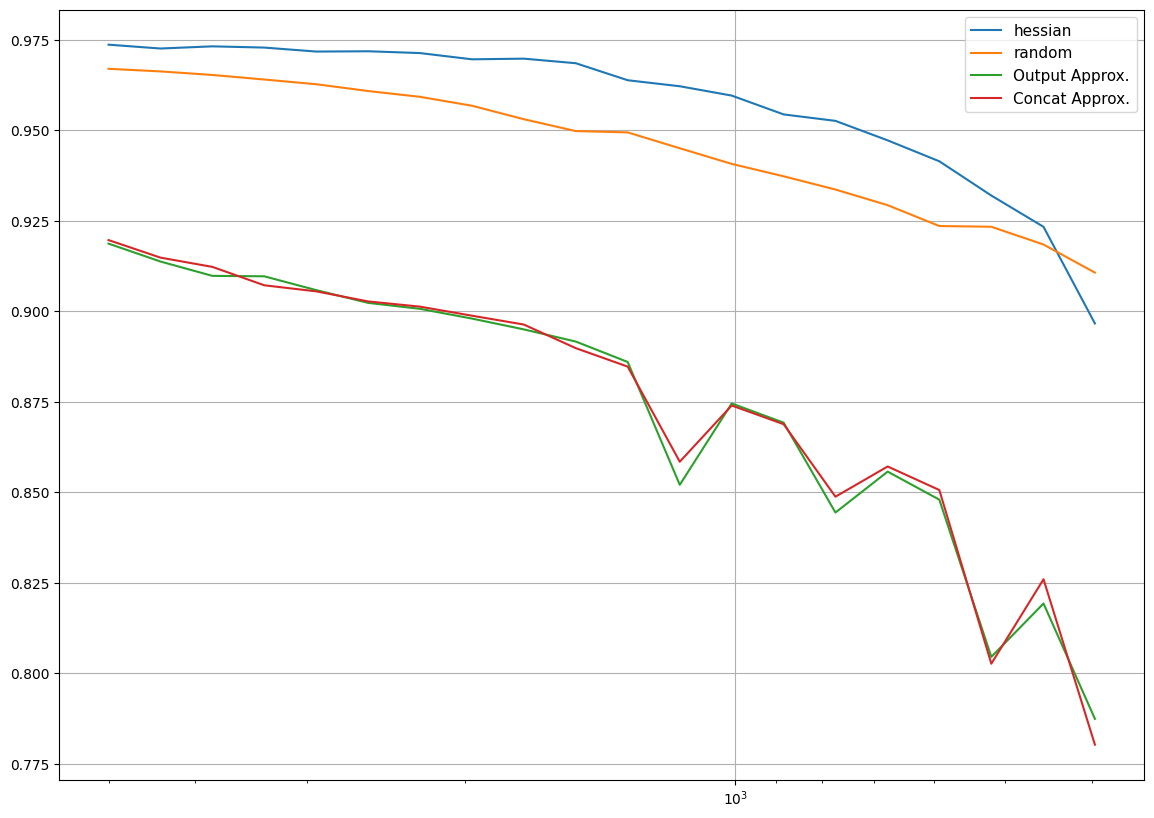

In [22]:
plot_accuracies([hess_val_acc, random_val_acc, out_approx_valacclist, concat_approx_valacclist], names=['hessian', 'random', 'Output Approx.', 'Concat Approx.'])

In [ ]:
input_based_low_val_acc, input_based_low_acc = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='low_to_high', shuffle_seed=1337)

In [ ]:
output_based_low_val_acc, output_based_low_acc = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='low_to_high', curvature_set='output', shuffle_seed=1337)

In [ ]:
input_based_high_val_acc, input_based_high_acc = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='high_to_low', shuffle_seed=1337)

In [ ]:
output_based_high_val_acc, output_based_high_acc = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='high_to_low', curvature_set='output', shuffle_seed=1337)

In [ ]:
input_based_low_high_val_acc, input_based_low_high_acc = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='extremes', shuffle_seed=1337)

In [ ]:
output_based_low_high_val_acc, output_based_low_high_acc = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='extremes', curvature_set='output', shuffle_seed=1337)

In [ ]:
input_based_mid_val_acc, input_based_mid_acc = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='mid', shuffle_seed=1337)

In [ ]:
output_based_mid_val_acc, output_based_mid_acc = get_accuracies(X_train, Y_train, X_test, Y_test, order_method='mid', curvature_set='output', shuffle_seed=1337)

In [18]:
methods = ['high', 'low', 'low_high', 'mid']
curv_types = ['in', 'out']
accuracies = []
for method in methods:
  for curv_type in curv_types:
    with open(f'mnist_{curv_type}_{method}_acc', 'rb') as file:
      accuracies.append(pickle.load(file))

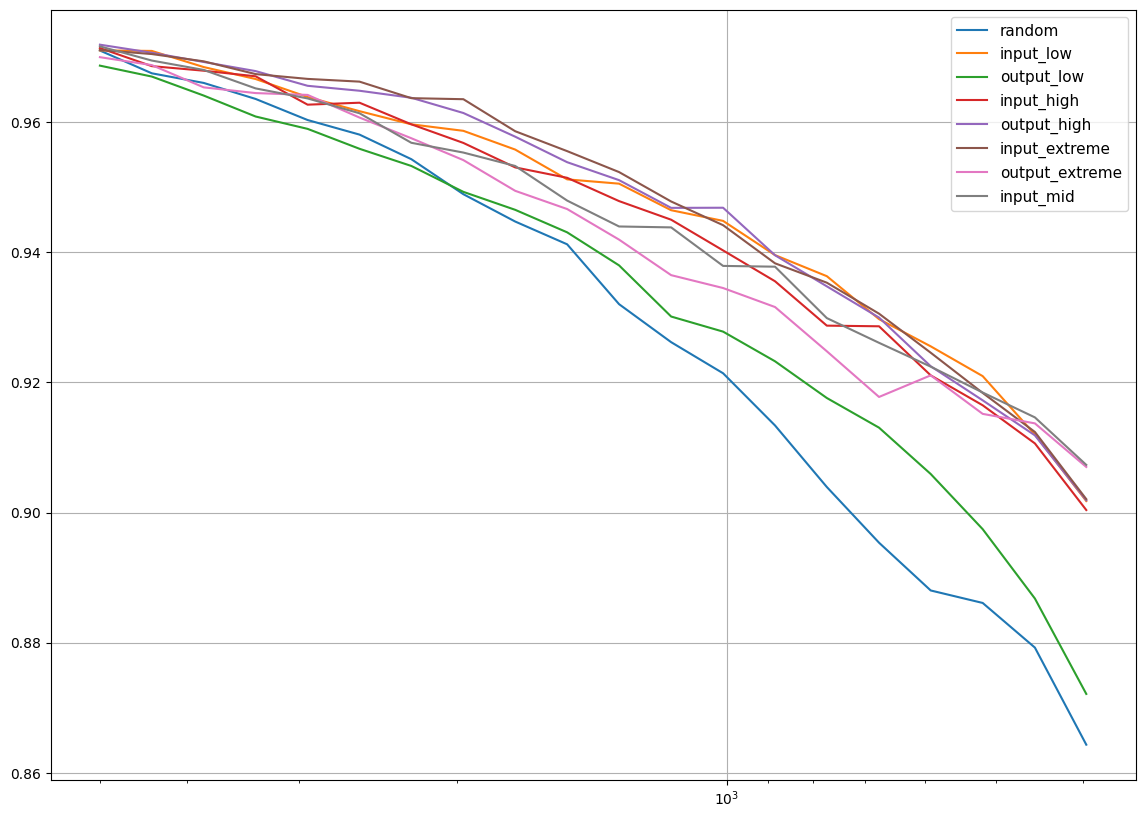

In [19]:
names = ['random', 'input_low', 'output_low', 'input_high', 'output_high', 'input_extreme', 'output_extreme', 'input_mid', 'output_mid']
plot_accuracies(accuracies, names)